In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
import missingno
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.metrics import accuracy_score

from matplotlib import font_manager, rc
font_path = "/content/drive/MyDrive/L1/Notebooks/dataset/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [8]:
ddf = pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/dataset_for_analysis.pkl')

In [9]:
# label, feature 분리
y_labels = ddf['spent_less']
X_features= ddf.drop('spent_less', axis=1)

In [10]:
# 비율확인
print(ddf['spent_less'].value_counts())
unsatisfied_cnt = ddf[ddf['spent_less'] == 1].spent_less.count()
total_cnt = ddf.spent_less.count()
print('spent_less 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0.0    8660
1.0    7635
Name: spent_less, dtype: int64
spent_less 비율은 0.47


In [11]:
# 학습, 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0) # stratify=y_labels?
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(13036, 45), 테스트 세트 Shape:(3259, 45)
 학습 세트 레이블 값 분포 비율
0.0    0.530608
1.0    0.469392
Name: spent_less, dtype: float64

 테스트 세트 레이블 값 분포 비율
0.0    0.534827
1.0    0.465173
Name: spent_less, dtype: float64


In [12]:
from sklearn.tree import DecisionTreeClassifier


# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
w_preds = dt_clf.predict(X_test)
w_preds_proba = dt_clf.predict_proba(X_test)[:,1]

- 과대 param 적용된 tree

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


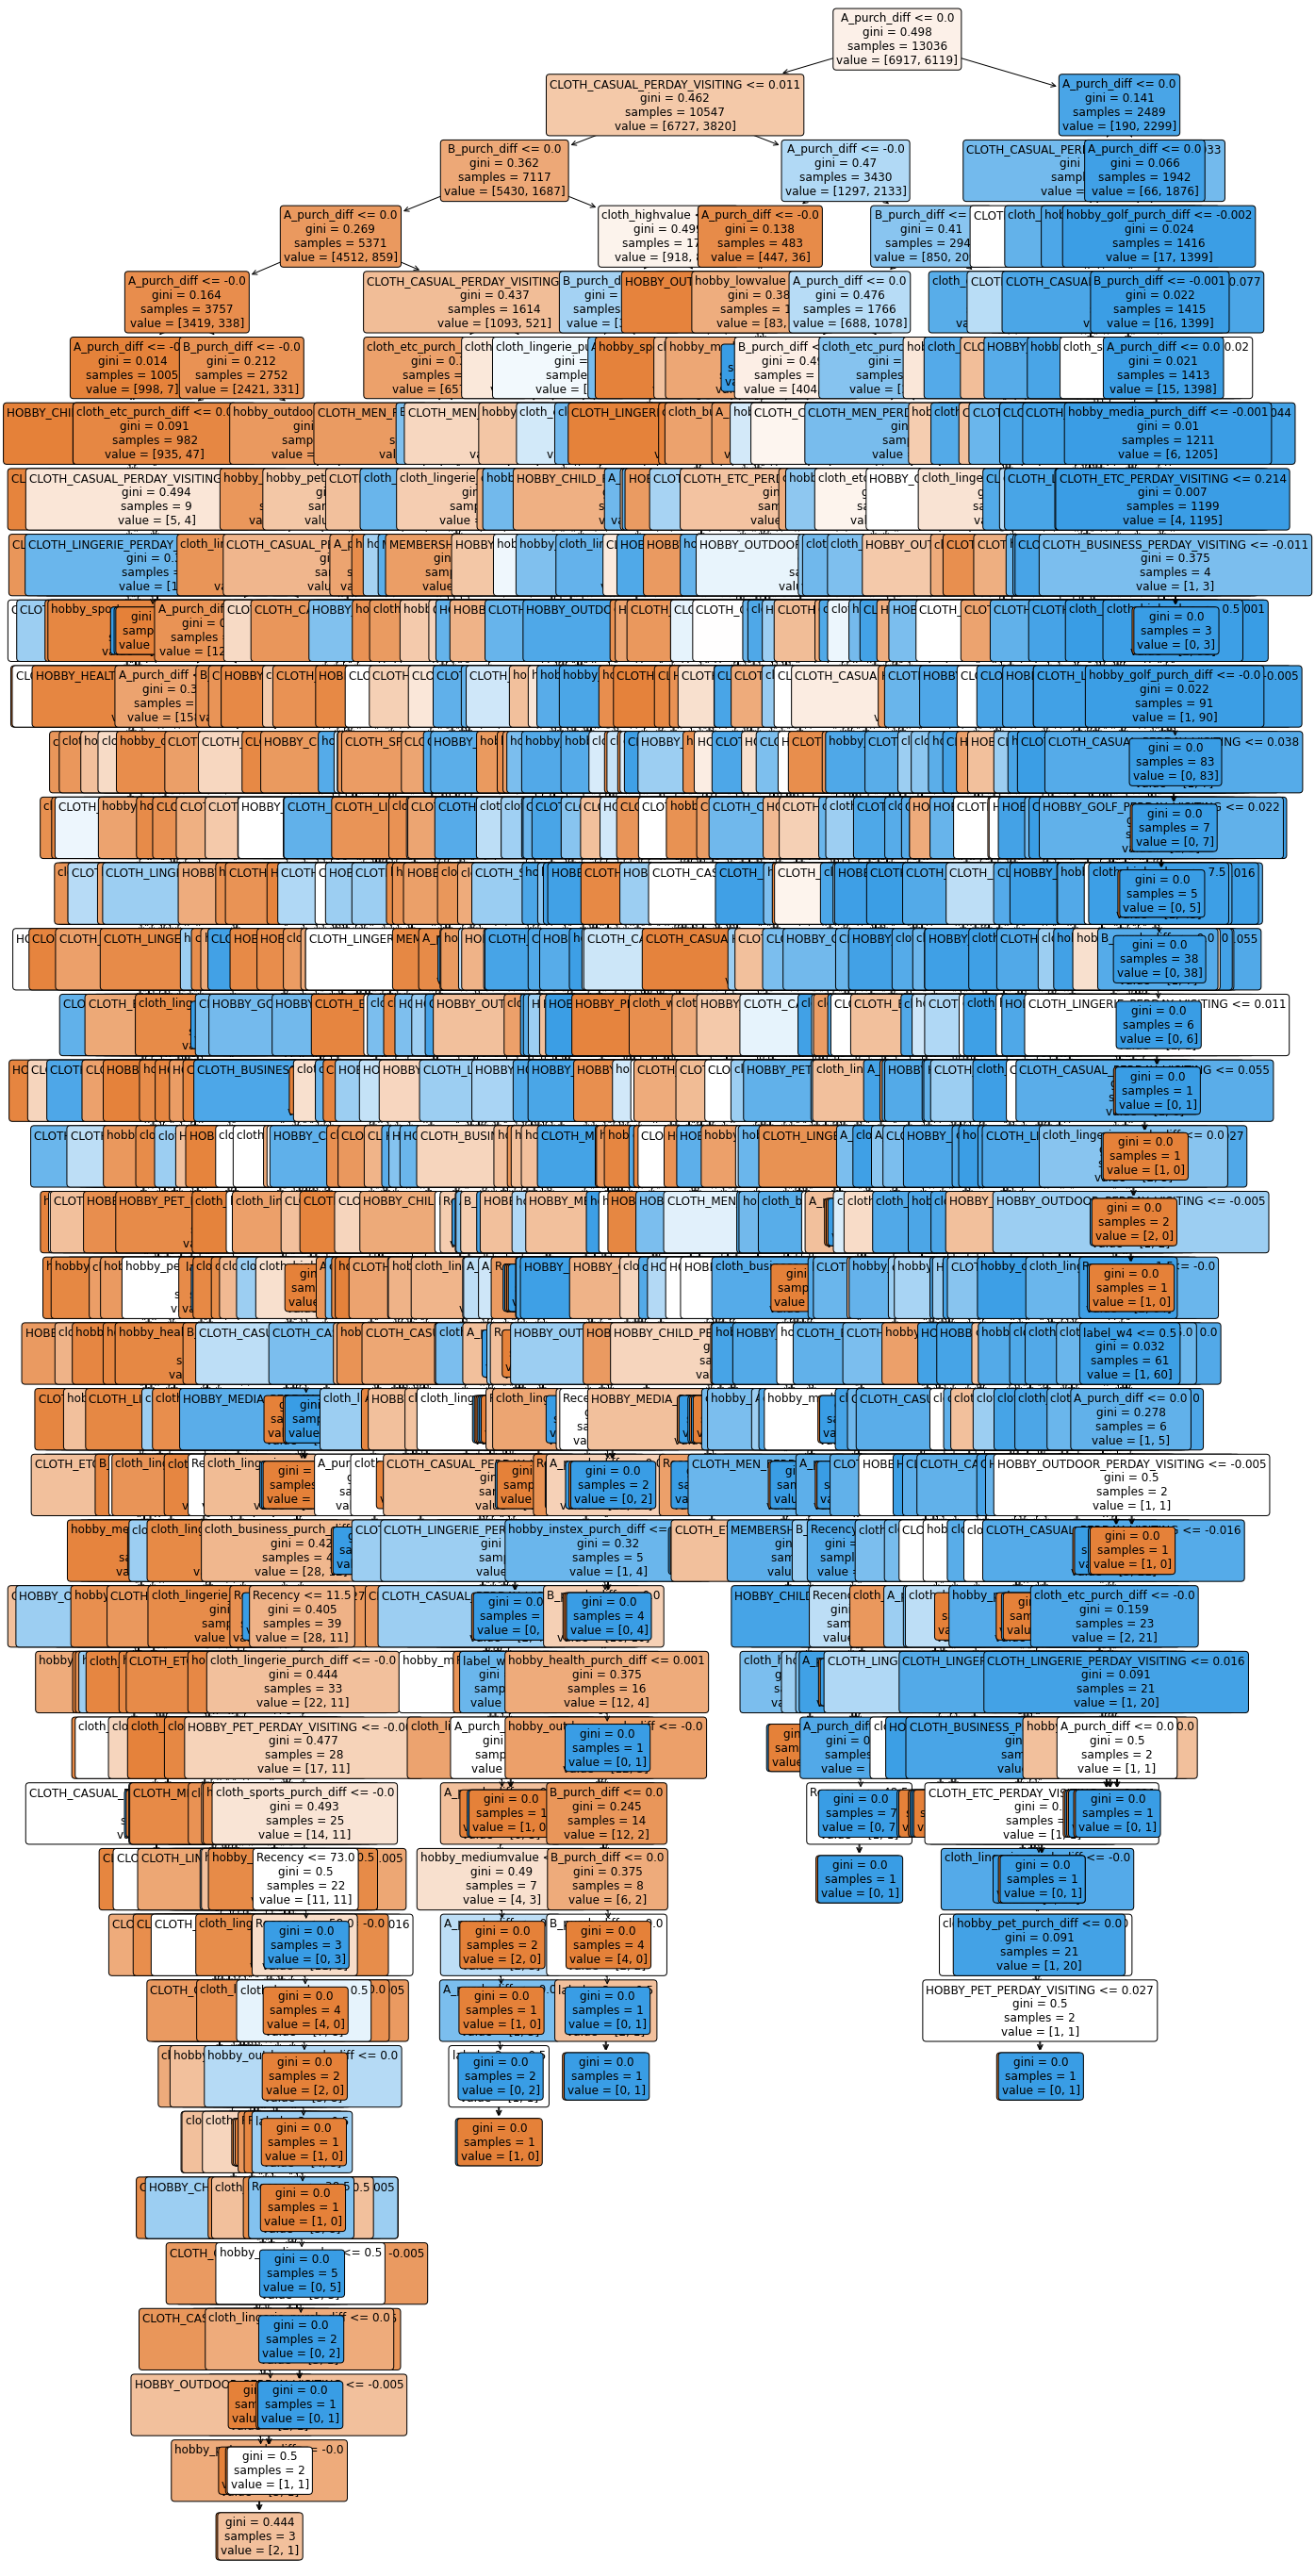

In [13]:
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

plt.figure(figsize=(20,50))
tree.plot_tree(dt_clf, filled=True,
              feature_names=X_train.columns,             
              rounded=True, fontsize=12)
plt.show()
plt.close()

In [14]:
from sklearn.tree import export_graphviz


export_graphviz(dt_clf, out_file="tree.dot", class_names=\
                ["decrease", "increase"],feature_names=X_train.columns,\
                impurity=False, filled=True, rounded=True)


# import graphviz

# with open("tree.dot",encoding='UTF-8') as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

- 정상? param 적용된 tree

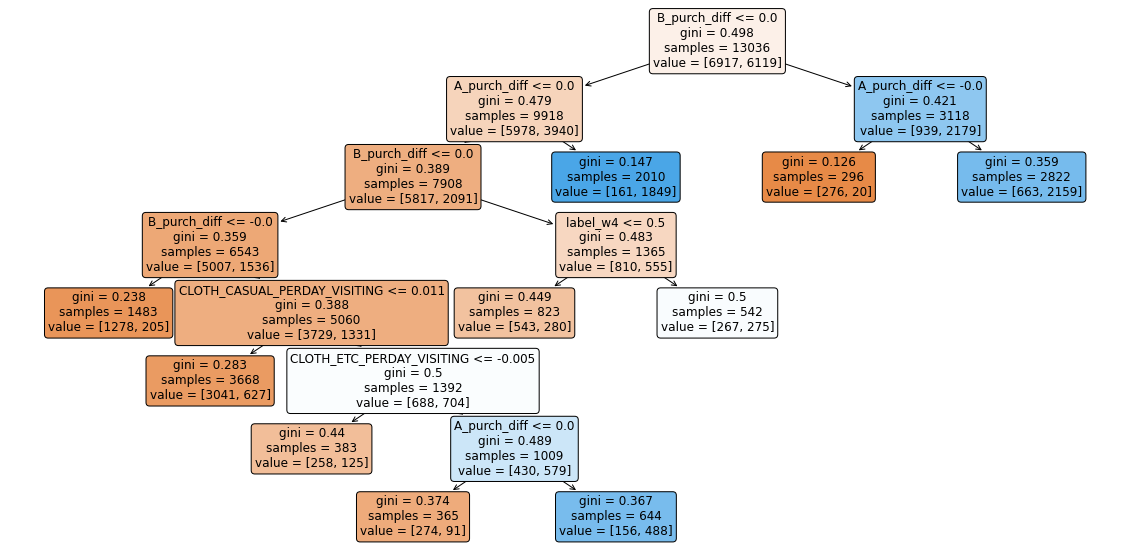

In [15]:


dt_clf = DecisionTreeClassifier(min_samples_leaf= 10,
                                min_samples_split=6,
                                max_features=10,
                                max_depth=10,
                                max_leaf_nodes=10)
dt_clf.fit(X_train,y_train)
w_preds = dt_clf.predict(X_test)
w_preds_proba = dt_clf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,10))
tree.plot_tree(dt_clf, filled=True,
              feature_names=X_train.columns,             
              rounded=True, fontsize=12)
plt.show()
plt.close()

In [16]:
temp = ddf.drop('spent_less', axis = 1)

Feature Importances: 
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.684  0.2077 0.     0.     0.     0.     0.     0.
 0.     0.     0.088  0.0132 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0071]
spent_less: 0.0000
cloth_lingerie_purch_diff: 0.0000
cloth_sports_purch_diff: 0.0000
cloth_etc_purch_diff: 0.0000
cloth_business_purch_diff: 0.0000
hobby_media_purch_diff: 0.0000
hobby_pet_purch_diff: 0.0000
hobby_outdoor_purch_diff: 0.0000
hobby_sports_purch_diff: 0.0000
hobby_health_purch_diff: 0.0000
hobby_instex_purch_diff: 0.0000
cloth_women_purch_diff: 0.0000
hobby_golf_purch_diff: 0.6840
A_purch_diff: 0.2077
B_purch_diff: 0.0000
Recency: 0.0000
cloth_highvalue: 0.0000
cloth_lowvalue: 0.0000
cloth_mediumvalue: 0.0000
hobby_highvalue: 0.0000
hobby_lowvalue: 0.0000
hobby_mediumvalue: 0.0000
CLOTH_MEN_PERDAY_VISITING: 0.0880
CLOTH_CASUAL_PERDAY_VISITING: 0.0132


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


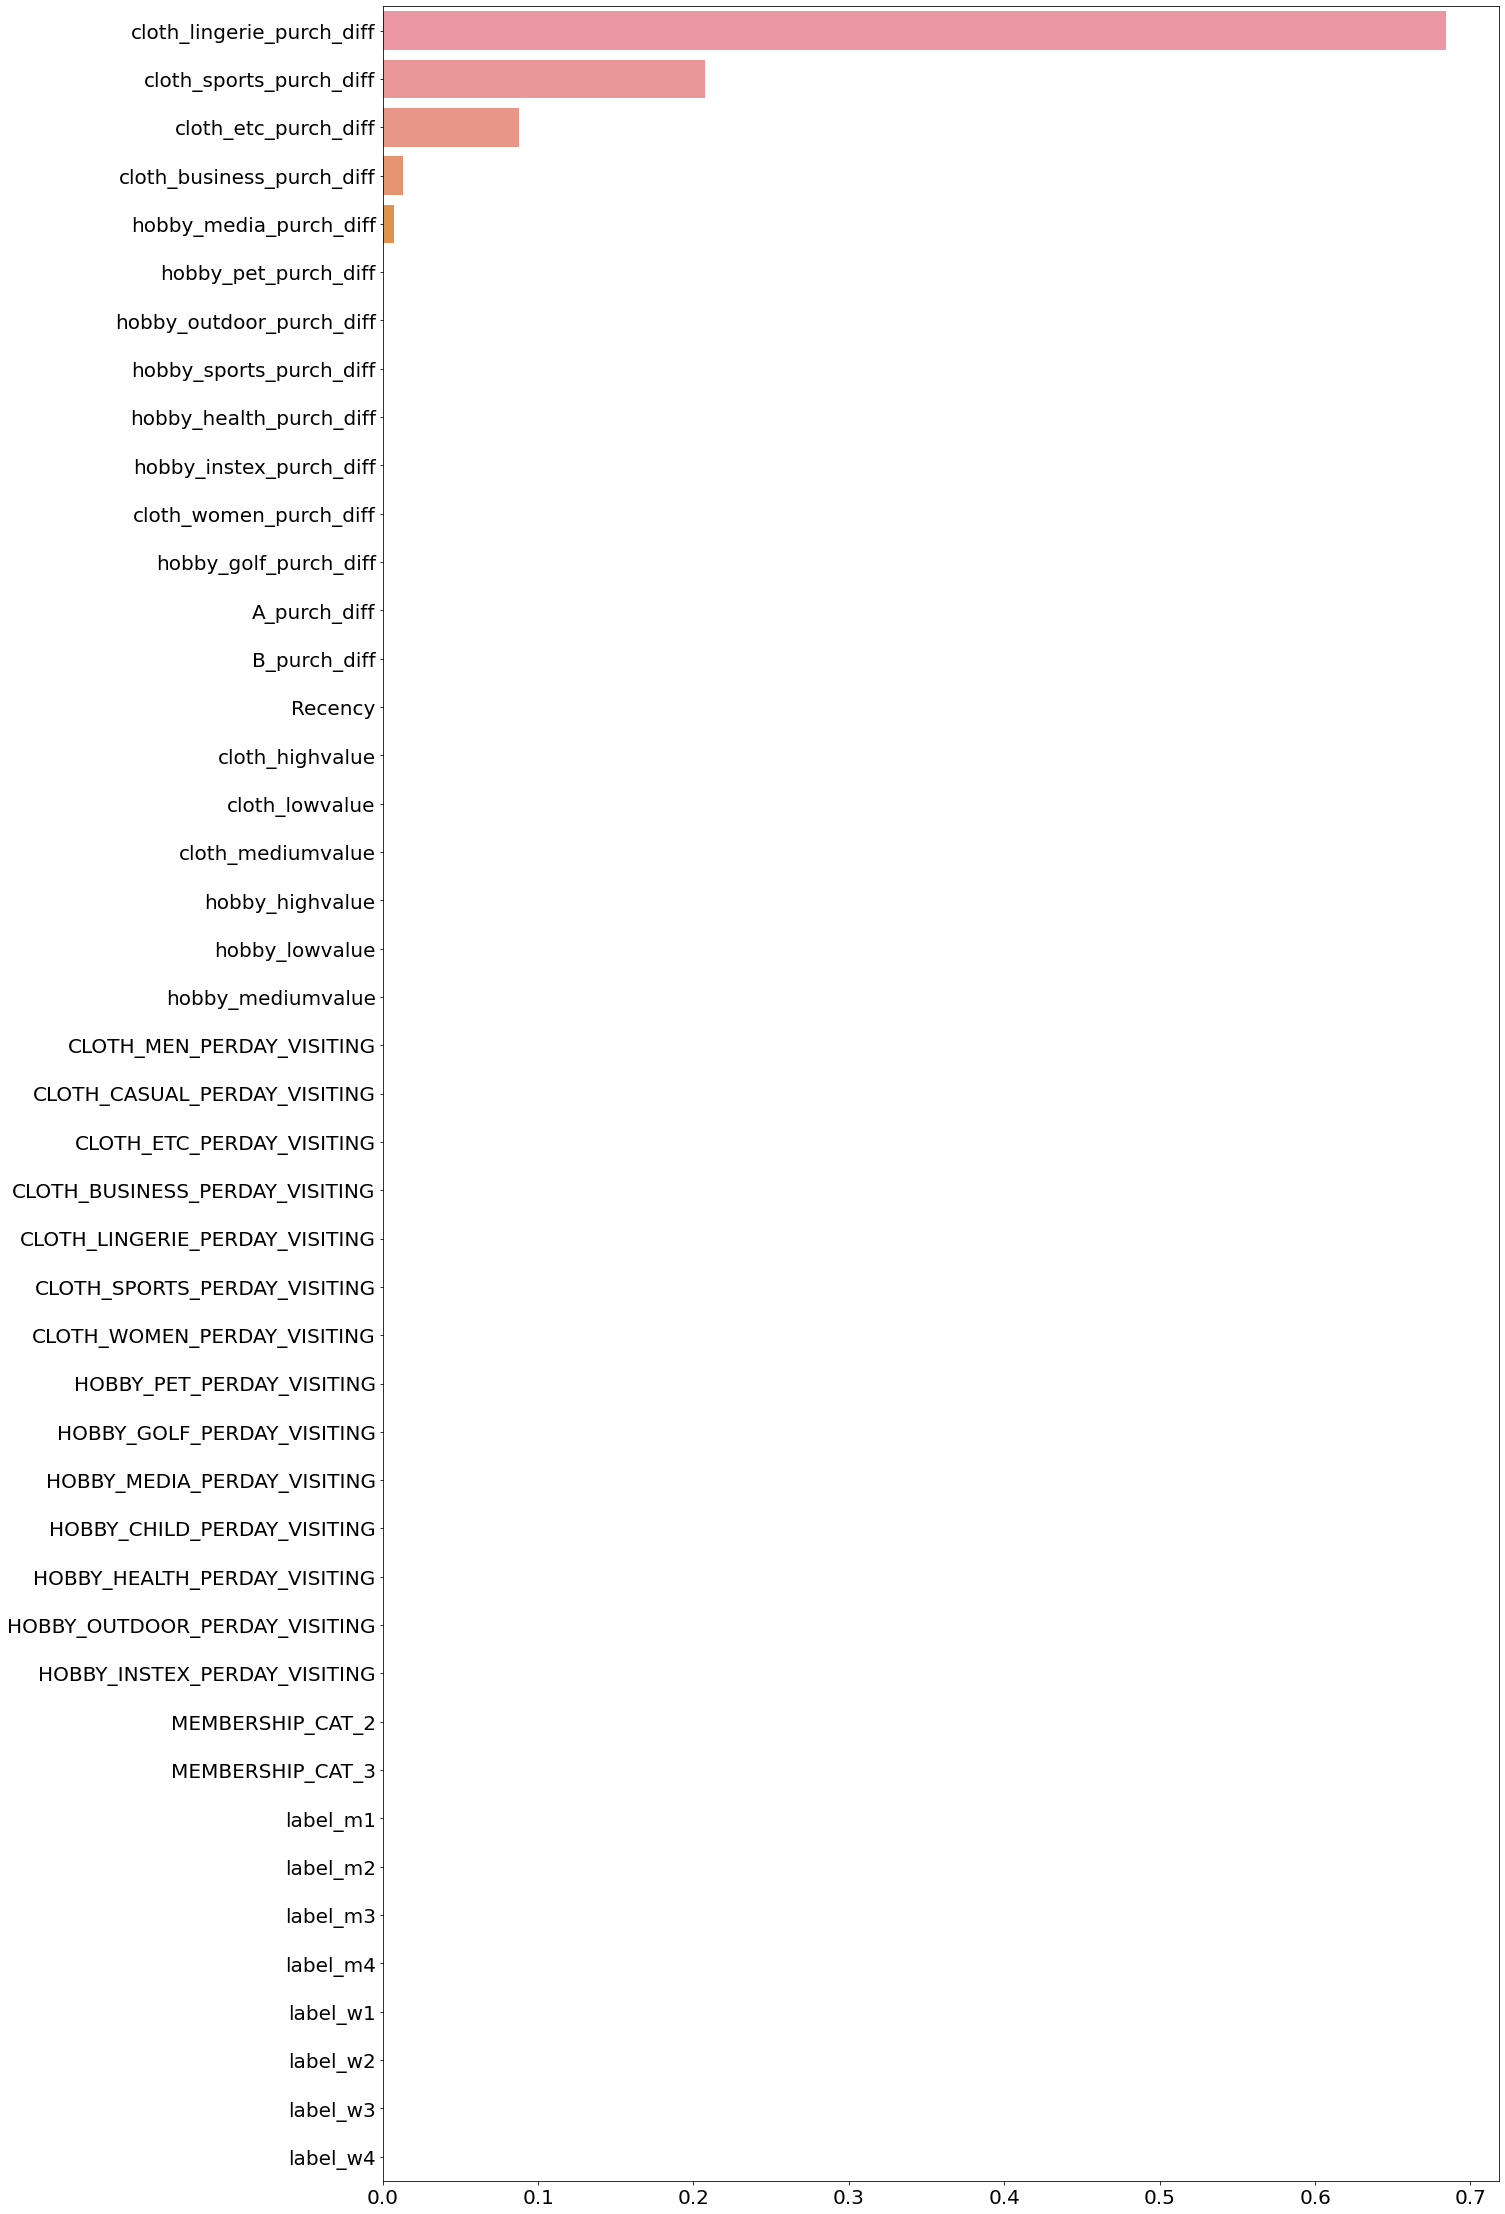

In [17]:
# feature importance 추출
print('Feature Importances: \n{0}'.\
     format(np.round(dt_clf.feature_importances_, 4)))
# feature별 importance 매핑
for name, value in \
zip(ddf.columns, dt_clf.feature_importances_):
    print('{0}: {1:.4f}'.format(name, value))

# feature importance를 column별로 시각화
plt.figure(figsize=(20,40))

g = sns.barplot(x = np.sort(dt_clf.feature_importances_)[::-1], 
            y = temp.columns)
g.tick_params(labelsize=20)

In [18]:
from sklearn.tree import export_graphviz
export_graphviz(dt_clf, out_file="tree.dot", class_names=\
                ["decrease", "increase"],feature_names=X_train.columns,\
                impurity=False, filled=True, rounded=True)
# import graphviz

# with open("tree.dot",encoding='UTF-8') as f:
#     dot_graph = f.read()
# display(graphviz.Source(dot_graph))

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC AUC는 pred 대신 pred_proba
    roc_score=roc_auc_score(y_test,pred_proba) # pred_proba

    print('오차행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, \
    f1 score:{3:.4f}, ROC AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_score))
get_clf_eval(y_test, w_preds, w_preds_proba)

오차행렬
[[1419  324]
 [ 387 1129]]
정확도:0.7818, 정밀도:0.7770, 재현율:0.7447,     f1 score:0.7605, ROC AUC:0.8171


최적 하이퍼파라미터 찾기

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [1, 2, 3, 4, 5, 10, 20, 30],  
         'min_samples_split': [1, 2, 3, 4, 5, 6, 10]}

grid_dtree = GridSearchCV(dt_clf, param_grid= params, cv=3, refit=True)
grid_dtree.fit(X_train, y_train)   

print('GCV 최적 하이퍼 파라미터:', grid_dtree.best_params_)   # 최적의 파라미터
print('GCV 최고 정확도:{0:.4f}'.format(grid_dtree.best_score_)) 

# esitimator = grid_dtree.best_estimator_ 
best_dtree = grid_dtree.best_estimator_  # 베스트 params가 적용된 estimator

dtpred = grid_dtree.predict(X_test)
accuracy = accuracy_score(y_test, dtpred) # 실제데이터와 비교 (정확도 확인)
print('DT 정확도:{0:.4f}'.format(accuracy)) 


GCV 최적 하이퍼 파라미터: {'max_depth': 5, 'min_samples_split': 2}
GCV 최고 정확도:0.7953
DT 정확도:0.7797


In [21]:
from sklearn.tree import DecisionTreeClassifier


# Decision Tree
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=6)
dt_clf.fit(X_train, y_train)
w_preds = dt_clf.predict(X_test)
w_preds_proba = dt_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, w_preds, w_preds_proba)

오차행렬
[[1492  251]
 [ 355 1161]]
정확도:0.8141, 정밀도:0.8222, 재현율:0.7658,     f1 score:0.7930, ROC AUC:0.8782
